In [19]:
import pandas as pd
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path
src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))
from preprocess_raw_parquet import preprocess_raw_parquet
from custom_loss_eval import eval_metrics
from plot_series import plot_series
from XGBoost import data_split, create_lag_features_fast
from prophet import Prophet
from pytorch_forecasting import TemporalFusionTransformer, DeepAR
import joblib
from prophet.serialize import model_from_json
import lightning.pytorch as pl
from transform_fee_data_dl import transform_fee_data_dl
from split_series import split_series
from scale_series import scale_series
from plot_series import plot_series
from custom_loss_eval import eval_metrics

In [20]:
PROJECT_ROOT = Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "mar_5_may_12.parquet"
MODEL_DIR = PROJECT_ROOT / "results" / "models"
PLOT_DIR = PROJECT_ROOT /"results"/"plots"
TABLE_DIR = PROJECT_ROOT /"results"/"tables"
OUTPUT_CSV = PROJECT_ROOT /"results"/"tables"/ "all_model_predictions.csv"

In [21]:
df_full = preprocess_raw_parquet(DATA_PATH)
df_full = df_full[:-96]
df_test = df_full.tail(96).copy()
df_test.reset_index(inplace=True)
df_test

,timestamp,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
0,2025-05-10 20:00:00,1.674466e+06,997984.750000,2088.000000,2.272682e+06,1.664282,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-05-10 20:15:00,1.601436e+06,997936.166667,3278.333333,3.632121e+06,2.680387,3.333333,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-05-10 20:30:00,1.563615e+06,997985.916667,3351.000000,4.477459e+06,3.377515,4.000000,3.333333,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-05-10 20:45:00,1.643071e+06,997973.333333,3545.333333,4.172588e+06,3.072167,4.000000,3.333333,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-05-10 21:00:00,1.673251e+06,997978.833333,2737.666667,3.769659e+06,3.106410,4.000000,3.333333,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2025-05-11 18:45:00,7.225843e+05,470774.833333,1282.333333,1.334593e+06,0.580391,1.333333,1.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,2025-05-11 19:00:00,3.872140e+05,240659.750000,819.666667,6.658160e+05,0.000000,1.000000,1.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,2025-05-11 19:15:00,1.479687e+06,917250.833333,2951.000000,2.899317e+06,2.102116,2.333333,1.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,2025-05-11 19:30:00,1.600430e+06,997964.500000,3674.333333,5.290451e+06,3.045255,4.000000,2.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
with open(MODEL_DIR /'prophet_model.json', 'r') as fin:
    prophet_model = model_from_json(fin.read())  # Load model

In [24]:
from torch.serialization import add_safe_globals
# Set the root directory of the project and add the advanced_tft scripts folder to the Python path
project_root = Path("../").resolve()
sys.path.insert(0, str(project_root / "scripts" / "advanced_tft"))

# Path to the model checkpoint file (This is the best one, use this for validation)
best_model_path = "../results/models/best-model-tft-v5.pt"
# Register TemporalFusionTransformer as a safe class for unpickling (required in PyTorch 2.6+)
add_safe_globals([TemporalFusionTransformer]) 
# Load the entire saved model (assuming it was saved using torch.save(model, path))
# Setting weights_only=False ensures the full object is deserialized
model = torch.load(best_model_path, map_location="cpu", weights_only=False)

In [ ]:
deepar_model = DeepAR.load_from_checkpoint(MODEL_DIR / "best_deepar_model_v5.ckpt")
_ = deepar_model.eval()

In [ ]:
with open(MODEL_DIR / "hwes_best_train.pkl", "rb") as f:
    hwes_model = pickle.load(f)


In [ ]:
with open(MODEL_DIR / "sarima_final_model.pkl", "rb") as f:
    sarima_model = pickle.load(f)

In [25]:
with open(MODEL_DIR / "xgboost.pkl", "rb") as f:
    xgb_model = joblib.load(MODEL_DIR / "xgboost.pkl")

In [ ]:
#hwes
FORECAST = len(df_test)
forecast = hwes_model.forecast(FORECAST)
forecast_hwes = pd.DataFrame(forecast, columns=["y_pred"])
forecast_hwes.reset_index(drop = True, inplace = True)
forecast_hwes["timestamp"] = df_test["timestamp"].values
forecast_hwes["series_id"] = "recommended_fee_fastestFee"
forecast_hwes["y_true"] = df_test["recommended_fee_fastestFee"]

In [ ]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_hwes, sid = "recommended_fee_fastestFee")
plt.title("HWES forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_hwes.png")
plt.close()

In [ ]:
hwes_result = eval_metrics(forecast_hwes["y_pred"], forecast_hwes["y_true"])
hwes_result

In [ ]:
#sarima
fh = list(range(1, FORECAST + 1))  # 1-based step index
y_pred_sarima_log = sarima_model.predict(fh=fh)
y_pred_sarima = np.expm1(y_pred_sarima_log)  # inverse of log1p

# Format result like HWES
forecast_sarima = pd.DataFrame(y_pred_sarima.values, columns=["y_pred"])
forecast_sarima["timestamp"] = df_test["timestamp"].values
forecast_sarima["series_id"] = "recommended_fee_fastestFee"
forecast_sarima["y_true"] = df_test["recommended_fee_fastestFee"]

In [ ]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_sarima, sid = "recommended_fee_fastestFee")
plt.title("Sarima forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_sarima.png")
plt.close()

In [ ]:
sarima_result = eval_metrics(forecast_sarima["y_pred"], forecast_sarima["y_true"])
sarima_result

In [26]:
#xgboost
# Generate lag features
lags = range(1, 193)
df_xgb_full = create_lag_features_fast(df_full, 'recommended_fee_fastestFee', lags)

# Split data
X_train, X_test, y_train, y_test = data_split(df_xgb_full, 15)

# Forecast using sktime-style forecaster
y_pred_xgboost = xgb_model.predict(fh=fh, X=X_test)

# Format like other forecasts
forecast_xgb = pd.DataFrame(y_pred_xgboost.values, columns=["y_pred"])
forecast_xgb["timestamp"] = df_test["timestamp"].values  # assumes df_test has timestamps aligned
forecast_xgb["series_id"] = "recommended_fee_fastestFee"
forecast_xgb["y_true"] = df_test["recommended_fee_fastestFee"]

<Figure size 1200x500 with 0 Axes>

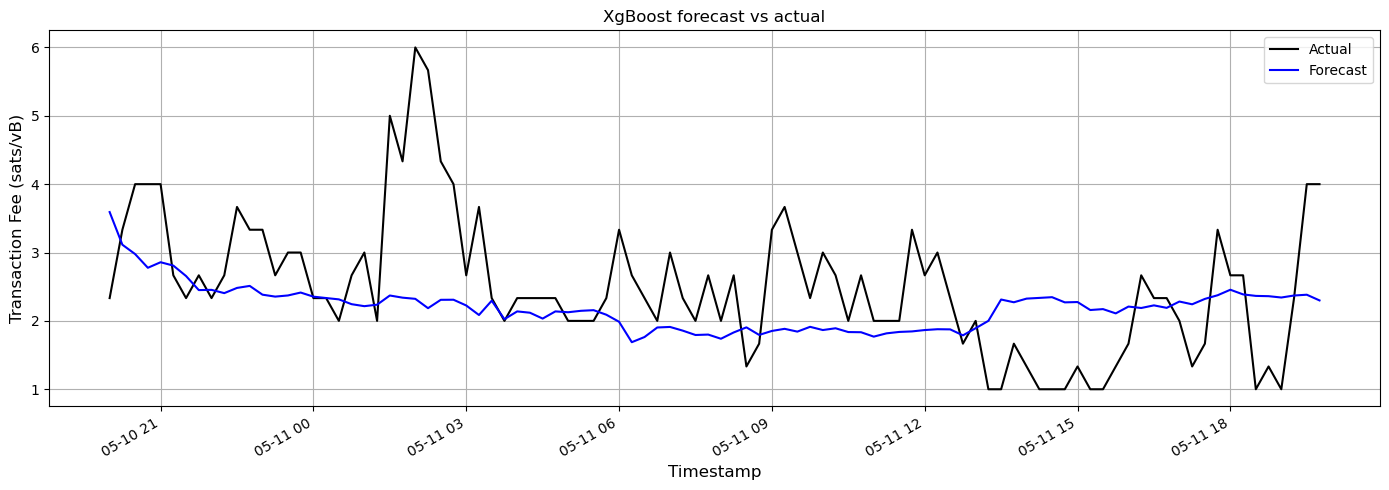

In [27]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_xgb, sid = "recommended_fee_fastestFee")
plt.title("XgBoost forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_xgboost.png")
plt.close()

In [28]:
xgb_result = eval_metrics(forecast_xgb["y_pred"], forecast_xgb["y_true"])
xgb_result

,value
custom_loss,2.2034
std_diff,0.6822
dev_error,0.7425
mae,0.7787
mape,0.3469
rmse,1.0410


In [29]:
#prophet
future = prophet_model.make_future_dataframe(periods=96, freq='15min')
forecast = prophet_model.predict(future)
y_pred_prophet = forecast.iloc[-96:]
y_pred_prophet = np.expm1(y_pred_prophet["yhat"])
forecast_prophet = pd.DataFrame(y_pred_prophet.values, columns=["y_pred"])
forecast_prophet["timestamp"] = df_test["timestamp"].values  # assumes df_test has timestamps aligned
forecast_prophet["series_id"] = "recommended_fee_fastestFee"
forecast_prophet["y_true"] = df_test["recommended_fee_fastestFee"]

In [30]:
prophet_result = eval_metrics(forecast_prophet["y_pred"], forecast_prophet["y_true"])
prophet_result

,value
custom_loss,2.4282
std_diff,0.4920
dev_error,0.9265
mae,1.0098
mape,0.5807
rmse,1.3430


<Figure size 1200x500 with 0 Axes>

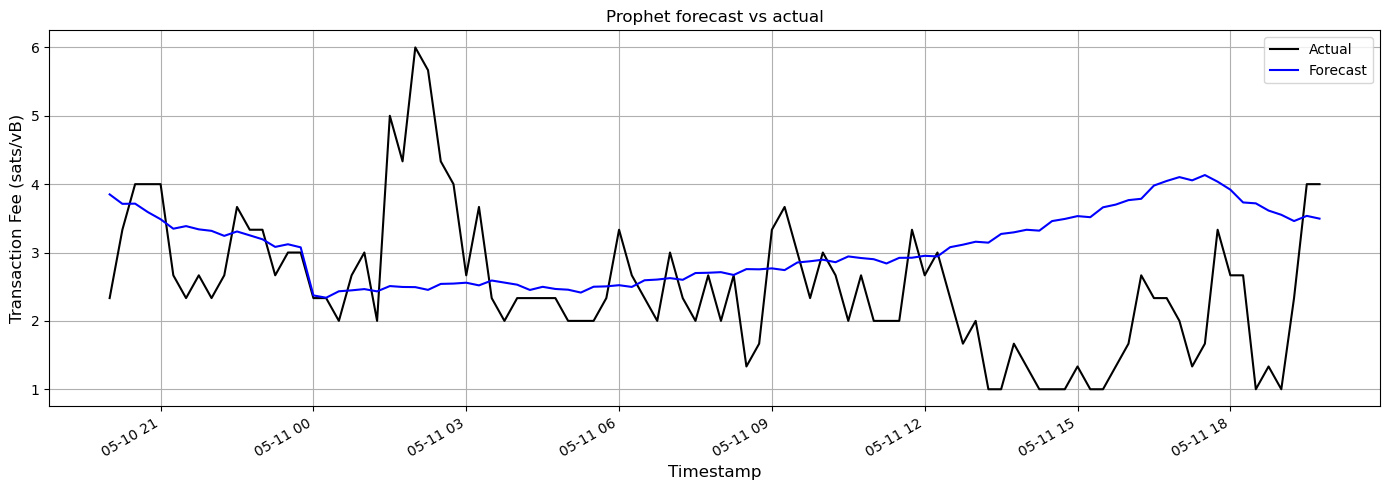

In [31]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_prophet, sid = "recommended_fee_fastestFee")
plt.title("Prophet forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_prophet.png")
plt.close()

In [ ]:
#deepar
df_deeplearning = transform_fee_data_dl(df_full)  # Adds time encodings, reshapes to long format, assigns time_idx
df_train_dl, df_valid_dl = split_series(df_deeplearning, 96)
df_train_dl, df_valid_dl, scaler = scale_series(df_train_dl, df_valid_dl)
df_true = df_valid_dl[
    lambda x: (x.time_idx > x.time_idx.max() - 96) & (x.time_idx <= x.time_idx.max())
]
pl.seed_everything(42)
raw_predictions = deepar_model.predict(
    df_valid_dl,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="cpu")
)
# Post-process prediction tensor → median forecast
pred_np = (
    raw_predictions.output.prediction.detach().cpu().numpy()
)  # Shape: (samples, series, time)
y_pred_da = np.median(pred_np, axis=-1).flatten()  

# Merge predictions with metadata and ground truth
df_eval_da = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        series_id=df_true["series_id"],
        y_true = df_true["target"],
        y_pred=y_pred_da,
        
    )
)
forecast_deepar = df_eval_da[df_eval_da["series_id"] == "recommended_fee_fastestFee"]


In [ ]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_deepar, sid = "recommended_fee_fastestFee")
plt.title("DeepAR forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_deepAR.png")
plt.close()

In [ ]:
deepar_result = eval_metrics(forecast_deepar["y_pred"], forecast_deepar["y_true"])
deepar_result

In [ ]:
#tft
# Predict using the loaded TFT model
pred = model.predict(
    df_valid_dl, # Since we have put target and other not known covariates into time_varying_unknown_reals. We can simply put df_valid here for prediction
    mode="raw",  # Return raw quantile outputs
    return_index=True,  # Return index values for later merging
    return_x=True,  # Return input data (x) as well
    trainer_kwargs=dict(accelerator="gpu"),  # Use GPU for faster inference
)
# Shape: (batch, decoder_length)
batch, pred_len = pred.x["decoder_time_idx"].shape

# Convert raw tensor to NumPy for post-processing
y_pred_tft = pred.output.prediction.detach().cpu().numpy().flatten()



# Combine predictions with true values and metadata
df_eval_tft = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        series_id=df_true["series_id"],
        y_true = df_true["target"],
        y_pred=y_pred_tft
    )
)

# Final output: ready for evaluation or visualization
forecast_tft = df_eval_tft[df_eval_tft["series_id"] == "recommended_fee_fastestFee"]

In [ ]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_tft, sid = "recommended_fee_fastestFee")
plt.title("TFT forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_tft.png")
plt.close()

In [ ]:
tft_result = eval_metrics(forecast_tft["y_pred"], forecast_tft["y_true"])
tft_result

In [ ]:
tft_result.columns = ["TFT"]
deepar_result.columns = ["DeepAR"]
prophet_result.columns = ["Prophet"]
sarima_result.columns = ["SARIMA"]
hwes_result.columns = ["HWES"]
xgb_result.columns = ["XGBoost"]

# Combine all
all_results_df = pd.concat([
    tft_result,
    deepar_result,
    prophet_result,
    sarima_result,
    hwes_result,
    xgb_result
], axis=1)

# Optional: round for readability
all_results_df = all_results_df.round(4)
all_results_df.to_csv(TABLE_DIR / "all_model_metrics.csv")
# Show combined result
all_results_df